# Hyperparameter Tuning for XGBoost Classifier
**Prepared by:** Adisorn Promkaewngarm

# Import Library

In [ ]:
!pip -q install mplfinance

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

import os, time, multiprocessing, psutil
from google.colab import output
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import mplfinance as mpf

# Import Data

In [ ]:
# GitHub Raw Data Paths
path_feature = 'https://raw.githubusercontent.com/adisorn242/2026_WQU_CapstoneProject/main/df_SET_features_weekly.csv'
path_label_train = 'https://raw.githubusercontent.com/adisorn242/2026_WQU_CapstoneProject/main/df_regime_labeling_traindata_weekly.csv'
path_set_data = 'https://raw.githubusercontent.com/adisorn242/2026_WQU_CapstoneProject/main/SET_Index_Weekly_2010_2025.csv'

# 1. Load the feature set
df_features = pd.read_csv(path_feature, index_col=0, parse_dates=True)

  # Train-Test split by period
df_features_train = df_features.loc[df_features.index.year < 2023].copy()
df_features_train = df_features_train.iloc[:, 1:] # Remove currnet return

  # Train-Test split by period
df_features_test = df_features.loc[df_features.index.year >= 2023,].copy()
df_features_test = df_features_test.iloc[:, 1:] # Remove currnet return

# 2. Load the training labels
df_labels = pd.read_csv(path_label_train, index_col=0, parse_dates=True)
df_labels_train = df_labels['Regime_ID'].copy()

# 3. Load the raw SET Index OHLC data
df_set_index = pd.read_csv(path_set_data, index_col=0, parse_dates=True)

In [ ]:
# 1. Check Training Set Alignment (Features vs. GM-HMM Labels)
train_indices_match = df_features_train.index.equals(df_labels_train.index)

# 2. Check Testing Set Alignment (Features vs. Raw SET Index)
#test_indices_match = df_features_test.index.equals(df_set_index_test.index)

# 3. Print Results
print("="*50)
print("INDEX CONSISTENCY VERIFICATION")
print("="*50)
print(f"Training Set Indices Match: {train_indices_match}")
#print(f"Testing Set Indices Match:  {test_indices_match}")
print("-" * 50)

# If they don't match, let's see where the discrepancy is
if not train_indices_match:
    print(f"Training Features: {len(df_features_train)} rows")
    print(f"Training Labels:   {len(df_labels_train)} rows")
    # Finding the difference
    diff = df_features_train.index.difference(df_labels_train.index)
    print(f"Missing dates in labels: {len(diff)}")

#if not test_indices_match:
  #  print(f"Testing Features:  {len(df_features_test)} rows")
  #  print(f"Testing SET Data:  {len(df_set_index_test)} rows")
#print("="*50)

INDEX CONSISTENCY VERIFICATION
Training Set Indices Match: True
--------------------------------------------------


# Data Normalization

In [ ]:
# 1. Initialize the Scaler
scaler = StandardScaler()

# 2. Fit and Transform the Training Data
X_train_scaled = scaler.fit_transform(df_features_train)

# 3. Transform the Testing Data (using the training parameters)
X_test_scaled = scaler.transform(df_features_test)

# Convert back to DataFrame to maintain column names for XGBoost
X_train_final = pd.DataFrame(X_train_scaled, index=df_features_train.index, columns=df_features_train.columns)
X_test_final = pd.DataFrame(X_test_scaled, index=df_features_test.index, columns=df_features_test.columns)

# Hyperparameter Tuning

In [ ]:
# Set to True to run hyperparameter tuning; Set to False once best_xgb_model is saved
run_tuning = False

if run_tuning:
    # Setup Model
    xgb_clf = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=3,
        random_state=42,
        eval_metric='mlogloss',
        tree_method='hist',
        device='cuda'
    )

    # Expanded Parameter Distribution for Randomized Search
    param_dist = {
        'n_estimators': [100, 150, 200, 250],
        'max_depth': [3, 4, 5, 6],
        'learning_rate': [0.01, 0.02, 0.03, 0.05, 0.1],
        'min_child_weight': [1, 2, 3, 5, 7],
        'subsample': [0.6, 0.7, 0.8, 0.9],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
        'gamma': [0, 0.1, 0.2, 0.5] # Adds a penalty for further partitioning
    }

    # Execution with TimeSeriesSplit
    # TimeSeriesSplit prevents data leakage by ensuring the training set
    # always precedes the validation set in time.
    tscv = TimeSeriesSplit(n_splits=5)

    # Testing 100 random combinations (500 total fits)
    random_search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=100,
        cv=tscv,
        scoring='accuracy',
        verbose=1,
        n_jobs=-1,
        random_state=42
    )

    start_time = time.time()
    random_search.fit(X_train_final, df_labels_train)
    duration = time.time() - start_time

    # Audio notification for Google Colab
    output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

    # Results
    print("\n" + "="*50)
    print(f"RANDOMIZED SEARCH COMPLETED")
    print(f"Total Time Spent:  {duration:.2f} seconds")
    print("-" * 50)
    print(f"Best Parameters:   {random_search.best_params_}")
    print(f"Best CV Accuracy:  {random_search.best_score_:.4f}")
    print("="*50)

    # Assign the best model to the variable for use in subsequent cells
    best_xgb_model = random_search.best_estimator_
else:
    print("Skipping tuning: Using previously defined best_xgb_model.")

Skipping tuning: Using previously defined best_xgb_model.


RANDOMIZED SEARCH COMPLETED
Total Time Spent:  573.55 seconds

Using Accuracy

Best Parameters:   {'subsample': 0.6, 'n_estimators': 250, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.6}
Best CV Accuracy:  0.5135

# Fitting Model

In [ ]:
# Initialize the final model with your latest optimized parameters
final_xgb_model = xgb.XGBClassifier(
    n_estimators=250,
    learning_rate=0.03,
    max_depth=5,
    min_child_weight=5,
    gamma=0.,
    subsample=0.6,
    colsample_bytree=0.6,

    # Static Configuration
    objective='multi:softmax',
    num_class=3,
    random_state=42,
    eval_metric='mlogloss',
    tree_method='hist',
    device='cuda'
)

# Fit the model using the training data and labels
final_xgb_model.fit(X_train_final, df_labels_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=0.0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None, num_class=3, ...)

In [ ]:
# 1. Predict for the Training Set (In-Sample)
y_train_pred = final_xgb_model.predict(X_train_final)
y_train_prob = final_xgb_model.predict_proba(X_train_final)

# 2. Predict for the Test Set (Out-of-Sample)
y_test_pred = final_xgb_model.predict(X_test_final)
y_test_prob = final_xgb_model.predict_proba(X_test_final)

# 3. Quick Check of Prediction Distribution
import pandas as pd
print("Regime Distribution in Test Set Predictions:")
print(pd.Series(y_test_pred).value_counts().sort_index())

Regime Distribution in Test Set Predictions:
0    97
1    33
2    27
Name: count, dtype: int64


TRAINING SET PERFORMANCE (IN-SAMPLE: 2011-2022)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       249
           1       1.00      1.00      1.00       201
           2       1.00      0.99      1.00       176

    accuracy                           1.00       626
   macro avg       1.00      1.00      1.00       626
weighted avg       1.00      1.00      1.00       626



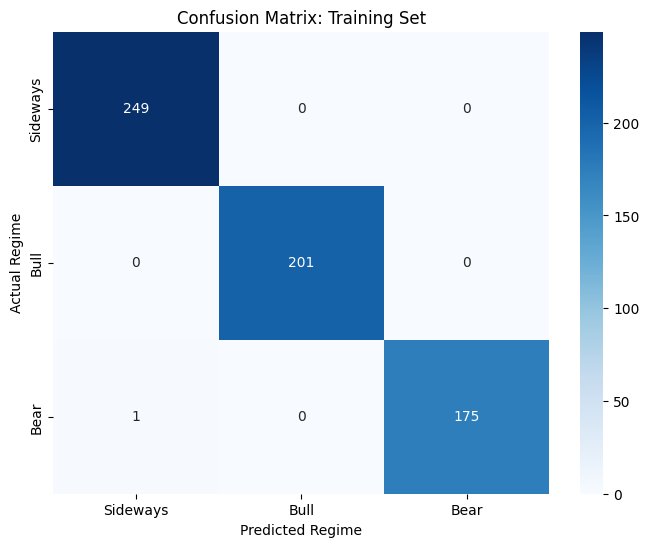

In [ ]:
# Classification Report for Training Data
print("="*60)
print("TRAINING SET PERFORMANCE (IN-SAMPLE: 2011-2022)")
print("="*60)
print(classification_report(df_labels_train, y_train_pred))

# Confusion Matrix for Training Data
cm_train = confusion_matrix(df_labels_train, y_train_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Sideways', 'Bull', 'Bear'],
            yticklabels=['Sideways', 'Bull', 'Bear'])
plt.title('Confusion Matrix: Training Set')
plt.xlabel('Predicted Regime')
plt.ylabel('Actual Regime')
plt.show()

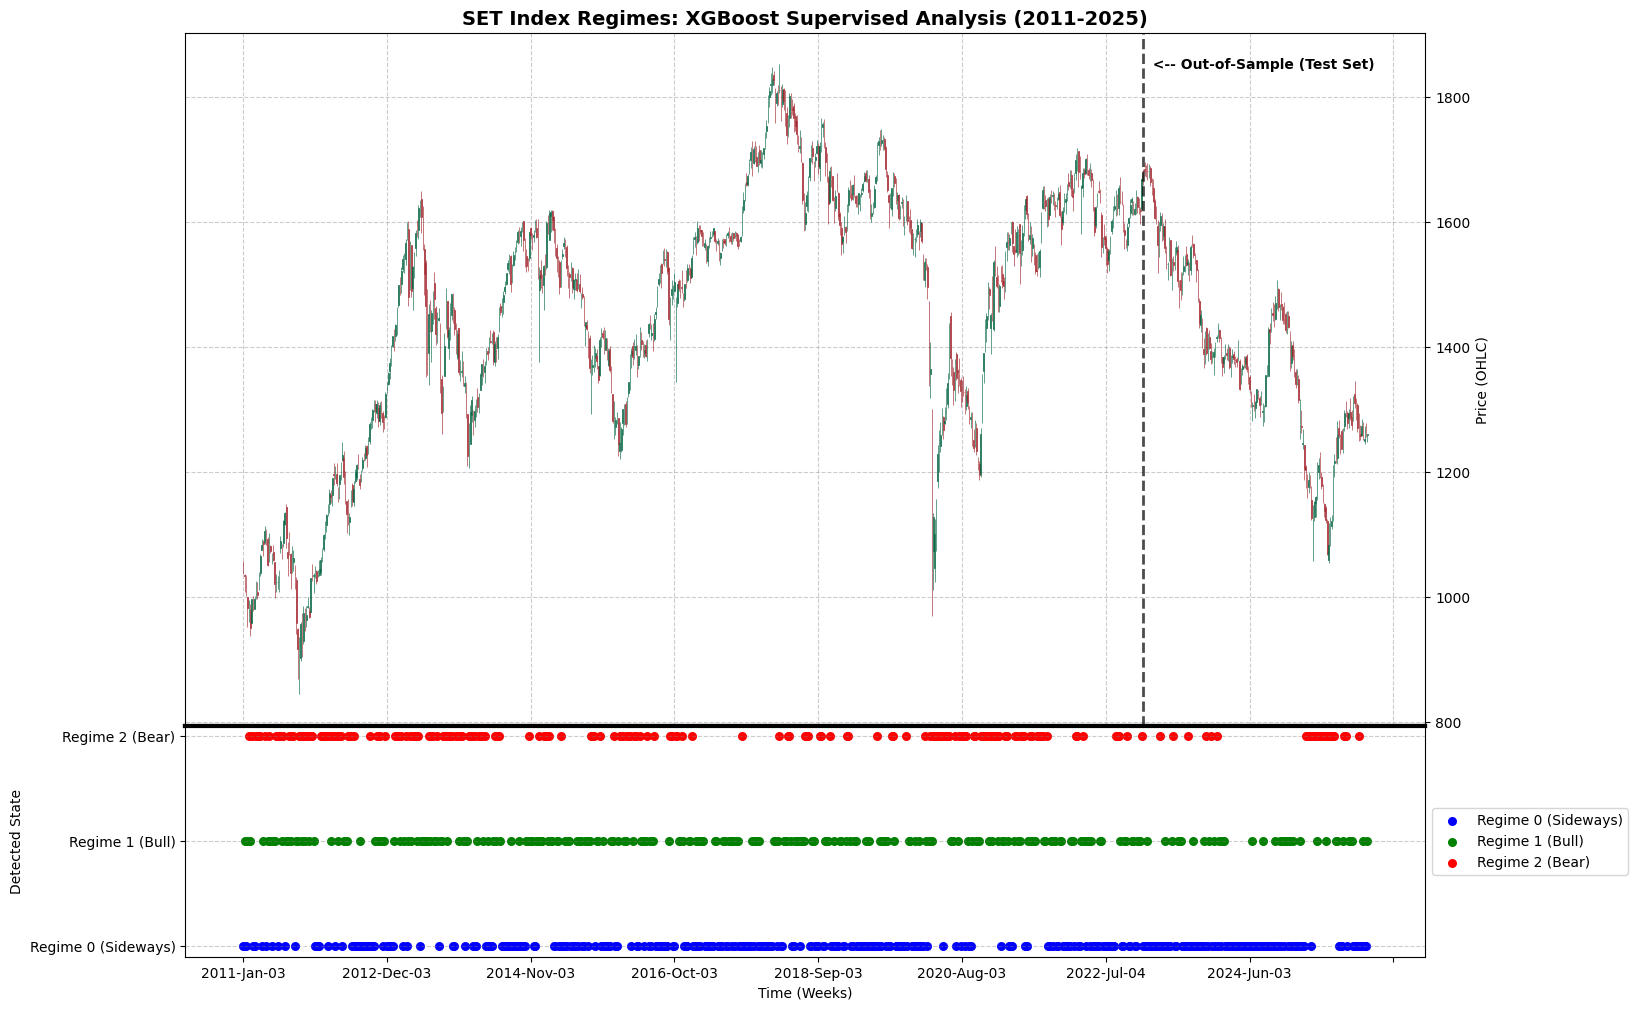

In [ ]:
# 1. Prepare Data for Visualization
# Combine indices and predictions
all_indices = X_train_final.index.append(X_test_final.index)
all_preds = np.concatenate([y_train_pred, y_test_pred])

# Use df_set_index for the OHLC data
df_candle = df_set_index.loc[all_indices, ['Open', 'High', 'Low', 'Close']].copy()
df_candle['Regime'] = all_preds

# Define Mapping and Labels
color_map = {0: 'blue', 1: 'green', 2: 'red'}
regime_labels = {0: 'Regime 0 (Sideways)', 1: 'Regime 1 (Bull)', 2: 'Regime 2 (Bear)'}

# 2. Final Visualization: Dual-Panel Candlestick & Regime Scatter
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True,
                               gridspec_kw={'height_ratios': [3, 1]})

# Top Panel: Candlestick Price Action
mpf.plot(
    df_candle,
    type='candle',
    style='charles',
    ax=ax1,
    show_nontrading=False
)
ax1.set_title('SET Index Regimes: XGBoost Supervised Analysis (2011-2025)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Price (OHLC)')

# Add a vertical line to indicate where the Training ends and Testing begins
split_idx = len(X_train_final)
ax1.axvline(x=split_idx, color='black', linestyle='--', linewidth=2, alpha=0.7)
ax1.text(split_idx, ax1.get_ylim()[1]*0.97, '  <-- Out-of-Sample (Test Set)', color='black', fontweight='bold')

# Clearer Grid for Price Panel
ax1.grid(True, which='both', linestyle='--', linewidth=0.8, color='gray', alpha=0.4)

# Bold Separator Line
ax1.spines['bottom'].set_linewidth(3)
ax1.spines['bottom'].set_color('black')

# Bottom Panel: Regime Identification Scatter Plot
x_axis = range(len(df_candle))
for r_id, r_color in color_map.items():
    mask = df_candle['Regime'] == r_id
    indices = [x_axis[i] for i in range(len(mask)) if mask.iloc[i]]
    ax2.scatter(indices, df_candle['Regime'][mask],
                color=r_color, s=30, label=regime_labels[r_id])

ax2.set_yticks([0, 1, 2])
ax2.set_yticklabels(['Regime 0 (Sideways)', 'Regime 1 (Bull)', 'Regime 2 (Bear)'])
ax2.set_ylabel('Detected State')
ax2.set_xlabel('Time (Weeks)')

# Clearer Grid for Regime Panel
ax2.grid(True, which='both', linestyle='--', linewidth=0.8, color='gray', alpha=0.4, axis='y')

# Bold Separator Line (Top of ax2)
ax2.spines['top'].set_linewidth(3)
ax2.spines['top'].set_color('black')

ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Eliminate gap between subplots for the single bold line effect
plt.subplots_adjust(hspace=0.0)

plt.show()

# Save Model

In [ ]:
if False: # Set true to export model
  model_filename = 'model_xgboost_regime_prediction.json'
  best_xgb_model.save_model(model_filename)